# Analysis of DTI-derived metrics (FA etc) within FS-segmented ROIs

BMED360-2021  `06-dmri-dti-feature-analysis-roi-wise.ipynb`

(assuming the `02-dmri-find-affine-fs-brainmask2dwi.ipynb` and `03-dmri-reconstruction-dti.ipynb` and `04-dmri-do-affine-reg-anat2dwi.ipynb` and `05-dmr-dti-feature-extraction-roi-wise.ipynb` notebooks have been executed)

<a href="https://colab.research.google.com/github/computational-medicine/BMED360-2021/blob/main/Lab3-diffusion-MRI/06-dmri-dti-feature-analysis-roi-wise">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Learning objectives:


Three major topics


- ### Brain ROIs according to Freesurfer segmentation
Check [FreeSurferColorLUT.txt](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/AnatomicalROI/FreeSurferColorLUT)  for the ROI-label for the different regions (left and right hemisphere)

```
# Below is the color table for a lobar white matter parcelation
#  obtained from running
# mri_annotation2label --subject subject --hemi lh --lobesStrict lobes
# mri_annotation2label --subject subject --hemi rh --lobesStrict lobes
# mri_aparc2aseg --s subject --labelwm --hypo-as-wm --rip-unknown \
#   --volmask --o wmparc.lobes.mgz --ctxseg aparc+aseg.mgz \
#   --annot lobes --base-offset 200 [--base-offset must be last arg]

3201    wm-lh-frontal-lobe                  235 35  95  0
3203    wm-lh-cingulate-lobe                35  75  35  0
3204    wm-lh-occiptal-lobe                 135 155 195 0
3205    wm-lh-temporal-lobe                 115 35  35  0
3206    wm-lh-parietal-lobe                 35  195 35  0
3207    wm-lh-insula-lobe                   20  220 160 0

4201    wm-rh-frontal-lobe                  235 35  95  0
4203    wm-rh-cingulate-lobe                35  75  35  0
4204    wm-rh-occiptal-lobe                 135 155 195 0
4205    wm-rh-temporal-lobe                 115 35  35  0
4206    wm-rh-parietal-lobe                 35  195 35  0
4207    wm-rh-insula-lobe                   20  220 160 0
```


- ### BIDS: Brain Imaging Dataset Specification
Now using `pybids` (https://github.com/bids-standard/pybids) (included by `pip install pybids` in the `environment.yml`file) to access the `./data/bids_bg_bmed360` information (e.g. `participants.tsv`)

- ### Permutation testing
Permutation tests are a group of nonparametric statistics. Here we use a permutation test to test the null hypothesis that two different groups come from the same distribution.

### For using Colab
**--> (some of) the following libraries must be `pip installed` (i.e. uncommet these among the following pip commands):**

In [1]:
#!pip install gdown
#!pip install nilearn
#!pip install dipy
#!pip install pybids

**Download a data file from Google Drive using gdown** (https://github.com/wkentaro/gdown)

In [2]:
import gdown
import shutil
import sys
import os
from os.path import expanduser, join, basename, split
import glob
import shutil
import platform

Check your platform for running this notebook

In [3]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install-win10')

OK, you are running on MacOS (Darwin Kernel Version 20.4.0: Fri Mar  5 01:14:14 PST 2021; root:xnu-7195.101.1~3/RELEASE_X86_64)


In [4]:
cwd = os.getcwd()

In [5]:
working_dir = join(cwd, 'data')
bids_dir = '%s/bids_bg_bmed360' % (working_dir)
dmri_res = '%s/dmri_results' % (working_dir)

In [6]:
# Download zip-file if ./data does not exist (as when running in Colab)

if os.path.isdir(working_dir) == False:
    
    ## Download data.zip for Google Drive            
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = './data.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data`
    shutil.unpack_archive(output, '.')
    
    ## Delete the `data.zip` file
    os.remove(output)
else:
    print(f'./data  exists already!')

./data  exists already!


In [7]:
# Download zip-file if ./data/dmri_results does not exist (as when running in Colab)

if os.path.isdir(dmri_res) == False:
    
    ## Download dmri_results.zip for Google Drive            
    # https://drive.google.com/file/d/1pX6Mx_9P8fojDXmbTz-th5FKFYZDVFuO/view?usp=sharing
    file_id = '1wu5pzAcE2hyZymq-IzuzKYGK_lMYbnJy'
    url = 'https://drive.google.com/uc?id=%s' % file_id
    output = 'dmri_results.zip'
    gdown.download(url, output, quiet=False)
    
    ## Unzip the assets file into `./data/dmri_results`
    shutil.unpack_archive(output, './data/')
    
    ## Delete the `dmri_results.zip` file
    os.remove(output)
else:
    print(f'./data/dmri_results  exists already!')

./data/dmri_results  exists already!


## Import libraries

In [8]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from os.path import expanduser, join, basename, split
import time
from dipy.io.image import save_nifti

**Relevant ROIs:**

In [9]:
rois = [3035, 4035,10, 49, 13, 52]
wm_dict = {3035: 'wm-lh-insula', 
           4035: 'wm-rh-insula',
             10: 'Left-Thalamus-Proper',
             49: 'Right-Thalamus-Proper',
             13: 'Left-Pallidum',
             52: 'Right-Pallidum'}
wm_dict

{3035: 'wm-lh-insula',
 4035: 'wm-rh-insula',
 10: 'Left-Thalamus-Proper',
 49: 'Right-Thalamus-Proper',
 13: 'Left-Pallidum',
 52: 'Right-Pallidum'}

### Mechanism to save dictionaries and lists as a binary .npy file

In [10]:
# Save
dictionary = {'hello':'world'}
np.save('%s/my_file.npy' % (dmri_res), dictionary) 

# Load
read_dictionary = np.load('%s/my_file.npy' % (dmri_res),allow_pickle='TRUE').item()
print(read_dictionary['hello']) # displays "world"

world


## Run for all subjects

In [11]:
outp_dir = dmri_res

In [12]:
# Load

for j in range(len(rois)):
    roi_num = rois[j]
    roi_name = wm_dict[rois[j]]
    read_dipy_dic = np.load('%s/%s_%d_dipy_dic.npy' % (outp_dir, roi_name, roi_num), allow_pickle='TRUE')
    
    print('ROI #%d: %s %d' % (j, wm_dict[rois[j]], rois[j]))
    print('- Subject', read_dipy_dic[0]['subj']) # displays 102
    print('-', read_dipy_dic[0]['meas_name'][0]) # displays fa
    print('-', read_dipy_dic[0]['meas_num'][0]) # displays number of voxels in region
    print('-', read_dipy_dic[0]['meas_val'][0]) # displays FA vector of length number of voxels in region
    print('-', read_dipy_dic[0]['meas_val'][0].mean().round(4)) # displays mean value of FA vector in region
    print('.....')
    print('- Subject', read_dipy_dic[-1]['subj']) # displays 123
    print('-', read_dipy_dic[-1]['meas_name'][0]) # displays fa
    print('-', read_dipy_dic[-1]['meas_num'][0]) # displays number of voxels in region
    print('-', read_dipy_dic[-1]['meas_val'][0]) # displays FA vector of length number of voxels in region
    print('-', read_dipy_dic[-1]['meas_val'][0].mean().round(4)) # displays mean value of FA vector in region

ROI #0: wm-lh-insula 3035
- Subject 102
- fa
- 1588
- [0.4070451  0.34805855 0.42998108 ... 0.24451551 0.37719929 0.25275582]
- 0.4911
.....
- Subject 123
- fa
- 1289
- [0.19441648 0.29957369 0.2641407  ... 0.10999358 0.06014513 0.26261741]
- 0.3884
ROI #1: wm-rh-insula 4035
- Subject 102
- fa
- 1625
- [0.56532001 0.5257057  0.64456826 ... 0.56478226 0.77072507 0.43658444]
- 0.4731
.....
- Subject 123
- fa
- 1201
- [0.39496666 0.52496779 0.41189063 ... 0.45212981 0.35864359 0.3720012 ]
- 0.4219
ROI #2: Left-Thalamus-Proper 10
- Subject 102
- fa
- 1414
- [0.19165075 0.19245476 0.2609424  ... 0.65007341 0.46091723 0.54429221]
- 0.372
.....
- Subject 123
- fa
- 1053
- [0.1215516  0.23493798 0.14775026 ... 0.30583057 0.51805598 0.35059491]
- 0.3062
ROI #3: Right-Thalamus-Proper 49
- Subject 102
- fa
- 1344
- [0.36227742 0.70933825 0.82158417 ... 0.16002595 0.2186504  0.23473842]
- 0.3512
.....
- Subject 123
- fa
- 822
- [0.65006459 0.5366962  0.62918907 0.3700721  0.43630597 0.38011476
 0.

In [13]:
# Read data for making a figure

roi_name = wm_dict[rois[0]]
roi_num = rois[0]

dipy_dic = np.load('%s/%s_%d_dipy_dic.npy' % (outp_dir, roi_name, roi_num), allow_pickle='TRUE')
sub = dipy_dic[-1]['subj']
meas_name = dipy_dic[-1]['meas_name']
meas_val = dipy_dic[-1]['meas_val']

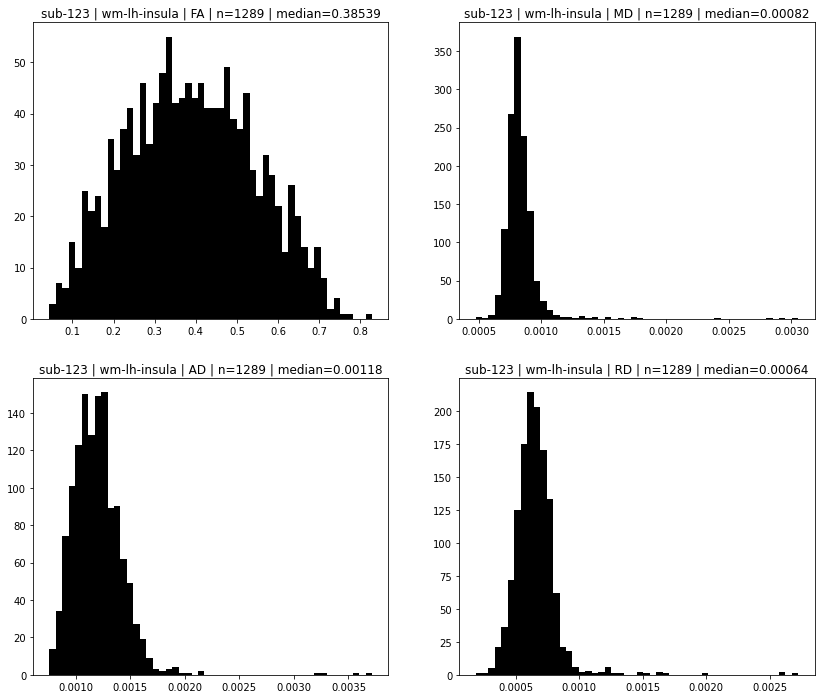

In [14]:
fig = plt.figure(figsize = [14, 12])
for i, meas in enumerate(meas_name):
    plt.subplot(2,2,i+1)
    plt.hist(meas_val[i],bins=50, color='black')
    plt.title('sub-%d | %s | %s | n=%d | median=%.5f' %
                  (sub, roi_name, meas_name[i].upper(), len(meas_val[i]), np.median(meas_val[i])))
plt.show()
#fig.savefig('%s/tmp/FIGURES/sub_%d_wmparc_%s_dti_features.png' % (home, sub, roi_name),
#           transparent=False, dpi=300, bbox_inches="tight")

# BIDS: Brain Imaging Dataset Specification

Recently, there has been growing interest to share datasets across labs and even on public repositories such as [openneuro](https://openneuro.org/). In order to make this a succesful enterprise, it is necessary to have some standards in how the data are named and organized. Historically, each lab has used their own idiosyncratic conventions, which can make it difficult for outsiders to analyze. In the past few years, there have been heroic efforts by the neuroimaging community to create a standardized file organization and naming practices. This specification is called **BIDS** for [Brain Imaging Dataset Specification](http://bids.neuroimaging.io/).

As you can imagine, individuals have their own distinct method of organizing their files. Think about how you keep track of your files on your personal laptop (versus your friend). This may be okay in the personal realm, but in science, it's best if anyone (especially  yourself 6 months from now!) can follow your work and know *which* files mean *what* by their titles.

Here's an example of non-Bids versus BIDS dataset found in [this paper](https://www.nature.com/articles/sdata201644):

![file_tree](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fsdata.2016.44/MediaObjects/41597_2016_Article_BFsdata201644_Fig1_HTML.jpg?as=webp)

Here are a few major differences between the two datasets:

1. In BIDS, files are in nifti format (not dicoms).
2. In BIDS, scans are broken up into separate folders by type of scan(functional versus anatomical versus diffusion weighted) for each subject.
3. In BIDS, JSON files are included that contain descriptive information about the scans (e.g., acquisition parameters)

Not only can using this specification be useful within labs to have a set way of structuring data, but it can also be useful when collaborating across labs, developing and utilizing software, and publishing data.

In addition, because this is a consistent format, it is possible to have a python package to make it easy to query a dataset. We recommend using [pybids](https://github.com/bids-standard/pybids).

The dataset we will be working with has already been converted to the BIDS format (see download localizer tutorial). 

You may need to install [pybids]() to query the BIDS datasets using following command `!pip install pybids` (in colab), or<br>
`conda install -c aramislab pybids` (old version 0.5.1 !) in the `bmed360` conda environment.

## The `BIDSLayout`
[Pybids](https://github.com/bids-standard/pybids) is a package to help query and navigate a neurogimaging dataset that is in the BIDs format. At the core of pybids is the `BIDSLayout` object. A `BIDSLayout` is a lightweight Python class that represents a BIDS project file tree and provides a variety of helpful methods for querying and manipulating BIDS files. While the BIDSLayout initializer has a large number of arguments you can use to control the way files are indexed and accessed, you will most commonly initialize a BIDSLayout by passing in the BIDS dataset root location as a single argument.

Notice we are setting `derivatives=True`. This means the layout will also index the derivatives sub folder, which might contain preprocessed data, analyses, or other user generated files. 

In [15]:
from os.path import expanduser, join
from bids import BIDSLayout, BIDSValidator
import os

#bids.config.set_option('extension_initial_dot', True)

data_dir = bids_dir
layout = BIDSLayout(data_dir, derivatives=False)
layout

/Users/arvid/opt/anaconda3/envs/bmed360/lib/python3.8/site-packages/bids/layout/models.py:148: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


BIDS Layout: ...usion-MRI/data/bids_bg_bmed360 | Subjects: 4 | Sessions: 8 | Runs: 0

When we initialize a BIDSLayout, all of the files and metadata found under the specified root folder are indexed. This can take a few seconds (or, for very large datasets, a minute or two). Once initialization is complete, we can start querying the BIDSLayout in various ways. The main query method is `.get()`. If we call .`get()` with no additional arguments, we get back a list of all the BIDS files in our dataset.

Let's return the first 10 files

In [16]:
layout.get()[:10]

[<BIDSJSONFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/data/bids_bg_bmed360/dataset_description.json'>,
 <BIDSJSONFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/data/bids_bg_bmed360/participants.json'>,
 <BIDSDataFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/data/bids_bg_bmed360/participants.tsv'>,
 <BIDSFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/data/bids_bg_bmed360/README'>,
 <BIDSJSONFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/data/bids_bg_bmed360/sub-102/ses-1/anat/sub-102_ses-1_T1w.json'>,
 <BIDSImageFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/data/bids_bg_bmed360/sub-102/ses-1/anat/sub-102_ses-1_T1w.nii.gz'>,
 <BIDSFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/data/bids_

When you call .get() on a BIDSLayout, the default returned values are objects of class BIDSFile. A BIDSFile is a lightweight container for individual files in a BIDS dataset. 

Here are some of the attributes and methods available to us in a BIDSFile (note that some of these are only available for certain subclasses of BIDSFile; e.g., you can't call get_image() on a BIDSFile that doesn't correspond to an image file!):

- .path: The full path of the associated file
- .filename: The associated file's filename (without directory)
- .dirname: The directory containing the file
- .get_entities(): Returns information about entities associated with this BIDSFile (optionally including metadata)
- .get_image(): Returns the file contents as a nibabel image (only works for image files)
- .get_df(): Get file contents as a pandas DataFrame (only works for TSV files)
- .get_metadata(): Returns a dictionary of all metadata found in associated JSON files
- .get_associations(): Returns a list of all files associated with this one in some way

Let's explore the first file in a little more detail.

In [17]:
f = layout.get()[0]
f

<BIDSJSONFile filename='/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/data/bids_bg_bmed360/dataset_description.json'>

If you want a summary of all the files in your BIDSLayout, but don't want to have to iterate BIDSFile objects and extract their entities, you can get a nice bird's-eye view of your dataset using the `to_df()` method.

In [18]:
layout.to_df().head()

entity,path,datatype,extension,session,subject,suffix,task
0,/Users/arvid/GitHub/computational-medicine/BME...,NaN,json,NaN,NaN,description,NaN
1,/Users/arvid/GitHub/computational-medicine/BME...,NaN,json,NaN,NaN,participants,NaN
2,/Users/arvid/GitHub/computational-medicine/BME...,NaN,tsv,NaN,NaN,participants,NaN
3,/Users/arvid/GitHub/computational-medicine/BME...,anat,json,1,102,T1w,NaN
4,/Users/arvid/GitHub/computational-medicine/BME...,anat,nii.gz,1,102,T1w,NaN


In [19]:
layout.description

{'Name': 'Brain-Gut-Microbiota',
 'BIDSVersion': '1.6',
 'License': 'MIT',
 'Authors': ['E. Valestrand',
  'B. Bertelsen',
  'T. Hausken',
  'A. Lundervold',
  ' et al.'],
 'Acknowledgements': '',
 'HowToAcknowledge': '',
 'Funding': ['NFR FRIMEDBIO',
  'Helse-Vest',
  'Trond Mohn Foundation / MMIV',
  ''],
 'ReferencesAndLinks': ['https://braingut.no', '', ''],
 'DatasetDOI': '',
 'TaskName': 'rest'}

In [20]:
layout.entities

{'subject': <bids.layout.models.Entity at 0x7fed389c5d90>,
 'session': <bids.layout.models.Entity at 0x7fed186d3ee0>,
 'task': <bids.layout.models.Entity at 0x7fed399cd550>,
 'acquisition': <bids.layout.models.Entity at 0x7fed399cdc40>,
 'ceagent': <bids.layout.models.Entity at 0x7fed399cd250>,
 'reconstruction': <bids.layout.models.Entity at 0x7fed399cd610>,
 'direction': <bids.layout.models.Entity at 0x7fed399cd4f0>,
 'run': <bids.layout.models.Entity at 0x7fed399cd640>,
 'proc': <bids.layout.models.Entity at 0x7fed399cd850>,
 'modality': <bids.layout.models.Entity at 0x7fed399cd400>,
 'echo': <bids.layout.models.Entity at 0x7fed399cd880>,
 'flip': <bids.layout.models.Entity at 0x7fed399cd820>,
 'inv': <bids.layout.models.Entity at 0x7fed399cd070>,
 'mt': <bids.layout.models.Entity at 0x7fed399cd220>,
 'part': <bids.layout.models.Entity at 0x7fed399da550>,
 'recording': <bids.layout.models.Entity at 0x7fed399da7f0>,
 'space': <bids.layout.models.Entity at 0x7fed399da580>,
 'suffix': 

In [21]:
layout.get_subjects()

['102', '103', '111', '123']

In [22]:
layout.get_sessions()

['1', '2']

In [23]:
layout.get_tasks()

['rest']

In [24]:
f = layout.get(extension='tsv')[0].filename
f

'participants.tsv'

In [25]:
fpath = layout.get(extension='tsv')[0].path
fpath

'/Users/arvid/GitHub/computational-medicine/BMED360-2021/Lab3-diffusion-MRI/data/bids_bg_bmed360/participants.tsv'

In [26]:
# df = pd.read_csv(fpath, sep='\t')  , or
df = pd.read_table(fpath)
df.T

,0,1,2,3
participant_id,sub-102,sub-103,sub-111,sub-123
gender,M,F,M,F
age,30,25,40,25
group,HC,HC,IBS,IBS
pre_soup_pain,1,1,2,15
pre_soup_nausea,1,2,2,0
pre_soup_fullnes,1,2,1,0
pre_soup_total,0,2,1,0
pre_soup_full,0,2,1,0
post_soup_pain,1,1,10,15


### Making groupwise concatenation of ROI-based (e.g. 'wm-lh-insula') DTI metrics (e.g. FA)

wm_dict = {3035: 'wm-lh-insula', 4035: 'wm-rh-insula'}

In [27]:
df.columns

Index(['participant_id', 'gender', 'age', 'group', 'pre_soup_pain',
       'pre_soup_nausea', 'pre_soup_fullnes', 'pre_soup_total',
       'pre_soup_full', 'post_soup_pain', 'post_soup_nausea',
       'post_soup_fullness', 'post_soup_total', 'post_soup_full',
       'num_glasses'],
      dtype='object')

In [28]:
HC_subj = df[df.group =='HC'].participant_id
IBS_subj = df[df.group =='IBS'].participant_id
print(f"IBS_subj:{IBS_subj}, HC_subj:{HC_subj}")

IBS_subj:2    sub-111
3    sub-123
Name: participant_id, dtype: object, HC_subj:0    sub-102
1    sub-103
Name: participant_id, dtype: object


In [29]:
list(IBS_subj.index), IBS_subj.iloc[0:4]

([2, 3],
 2    sub-111
 3    sub-123
 Name: participant_id, dtype: object)

In [30]:
HC_idx = list(HC_subj.index)
IBS_idx = list(IBS_subj.index)
print(f"IBS_idx:{IBS_idx}, HC_idx:{HC_idx}")

IBS_idx:[2, 3], HC_idx:[0, 1]


### The ROIs

In [31]:
rois = [3035, 4035, 10, 49, 13, 52]
wm_dict = {3035: 'wm-lh-insula', 
           4035: 'wm-rh-insula',
             10: 'Left-Thalamus-Proper',
             49: 'Right-Thalamus-Proper',
             13: 'Left-Pallidum',
             52: 'Right-Pallidum'}

### The FA values for the HC group

In [32]:
for j in range(len(rois)):
    roi_num = rois[j]
    roi_name = wm_dict[rois[j]]
    print('\nj=%d' % (j), roi_name, roi_num)
    np_array = np.array([], dtype=np.float64)  # initialize
    read_dipy_dic = np.load('%s/%s_%d_dipy_dic.npy' % (outp_dir, roi_name, roi_num), allow_pickle='TRUE')
    for i in range(len(HC_idx)):
        print(i, 
              read_dipy_dic[HC_idx[i]]['subj'], 
              read_dipy_dic[HC_idx[i]]['meas_name'][0],
              read_dipy_dic[HC_idx[i]]['meas_num'][0])
              # read_dipy_dic[HC_idx[i]]['meas_val'][0])
        np_array = np.concatenate([np_array, np.array(list(read_dipy_dic[HC_idx[i]]['meas_val'][0]))])
    fn = '%s/HC_%s_%s_FA.npy' % (outp_dir, roi_name, roi_num)
    np.save(fn, np_array)   # to load: np_array = np.load(fn)


j=0 wm-lh-insula 3035
0 102 fa 1588
1 103 fa 1380

j=1 wm-rh-insula 4035
0 102 fa 1625
1 103 fa 1580

j=2 Left-Thalamus-Proper 10
0 102 fa 1414
1 103 fa 1280

j=3 Right-Thalamus-Proper 49
0 102 fa 1344
1 103 fa 1063

j=4 Left-Pallidum 13
0 102 fa 334
1 103 fa 252

j=5 Right-Pallidum 52
0 102 fa 356
1 103 fa 306


## The FA values for the IBS group

In [33]:
for j in range(len(rois)):
    roi_num = rois[j]
    roi_name = wm_dict[rois[j]]
    print('\nj=%d' % (j), roi_name, roi_num)
    np_array = np.array([], dtype=np.float64)  # initialize
    read_dipy_dic = np.load('%s/%s_%d_dipy_dic.npy' % (outp_dir, roi_name, roi_num), allow_pickle='TRUE')
    for i in range(len(IBS_idx)):
        print(i, 
              read_dipy_dic[IBS_idx[i]]['subj'], 
              read_dipy_dic[IBS_idx[i]]['meas_name'][0],
              read_dipy_dic[IBS_idx[i]]['meas_num'][0])
              # read_dipy_dic[IBS_idx[i]]['meas_val'][0])
        np_array = np.concatenate([np_array, np.array(list(read_dipy_dic[IBS_idx[i]]['meas_val'][0]))])
    fn = '%s/IBS_%s_%s_FA.npy' % (outp_dir, roi_name, roi_num)
    np.save(fn, np_array)   # to load: np_array = np.load(fn)


j=0 wm-lh-insula 3035
0 111 fa 1590
1 123 fa 1289

j=1 wm-rh-insula 4035
0 111 fa 1632
1 123 fa 1201

j=2 Left-Thalamus-Proper 10
0 111 fa 1193
1 123 fa 1053

j=3 Right-Thalamus-Proper 49
0 111 fa 1256
1 123 fa 822

j=4 Left-Pallidum 13
0 111 fa 354
1 123 fa 267

j=5 Right-Pallidum 52
0 111 fa 332
1 123 fa 286


## The MD values for the HC group

In [34]:
rois = [3035, 4035]
wm_dict = {3035: 'wm-lh-insula', 4035: 'wm-rh-insula'}
wm_dict[rois[0]]

for j in range(len(rois)):
    roi_num = rois[j]
    roi_name = wm_dict[rois[j]]
    print('\nj=%d' % (j), roi_name, roi_num)
    read_dipy_dic = np.load('%s/%s_%d_dipy_dic.npy' % (outp_dir, roi_name, roi_num), allow_pickle='TRUE')
    for i in range(len(HC_idx)):
        print(i, 
              read_dipy_dic[HC_idx[i]]['subj'], 
              read_dipy_dic[HC_idx[i]]['meas_name'][1],
              read_dipy_dic[HC_idx[i]]['meas_num'][1],
              read_dipy_dic[HC_idx[i]]['meas_val'][1])


j=0 wm-lh-insula 3035
0 102 md 1588 [0.00092362 0.00074782 0.00085944 ... 0.00090727 0.00063777 0.00078737]
1 103 md 1380 [0.00092257 0.00089606 0.0008941  ... 0.00072269 0.00084111 0.00080581]

j=1 wm-rh-insula 4035
0 102 md 1625 [0.00078896 0.00081551 0.00081203 ... 0.00063328 0.00082302 0.0010128 ]
1 103 md 1580 [0.0009014  0.00084932 0.00083797 ... 0.00132301 0.00168569 0.00219721]


## The MD values for the IBS group

In [35]:
rois = [3035, 4035]
wm_dict = {3035: 'wm-lh-insula', 4035: 'wm-rh-insula'}
wm_dict[rois[0]]

for j in range(len(rois)):
    roi_num = rois[j]
    roi_name = wm_dict[rois[j]]
    print('\nj=%d' % (j), roi_name, roi_num)
    read_dipy_dic = np.load('%s/%s_%d_dipy_dic.npy' % (outp_dir, roi_name, roi_num), allow_pickle='TRUE')
    for i in range(len(IBS_idx)):
        print(i, 
              read_dipy_dic[IBS_idx[i]]['subj'], 
              read_dipy_dic[IBS_idx[i]]['meas_name'][1],
              read_dipy_dic[IBS_idx[i]]['meas_num'][1],
              read_dipy_dic[IBS_idx[i]]['meas_val'][1].round(8))


j=0 wm-lh-insula 3035
0 111 md 1590 [0.00085615 0.00081088 0.00049785 ... 0.00101102 0.0007691  0.00084312]
1 123 md 1289 [0.00294001 0.00241987 0.00145474 ... 0.00105047 0.00138827 0.00093835]

j=1 wm-rh-insula 4035
0 111 md 1632 [0.00071861 0.00098699 0.00096045 ... 0.00098962 0.0010616  0.00072952]
1 123 md 1201 [0.00089351 0.00089231 0.00090452 ... 0.00082227 0.00086629 0.00080585]


#### We should make functions out of this, avoiding all the repetitions ...

## Make a  2x2 figure of the group- and ROI-wise distrubutions of FA

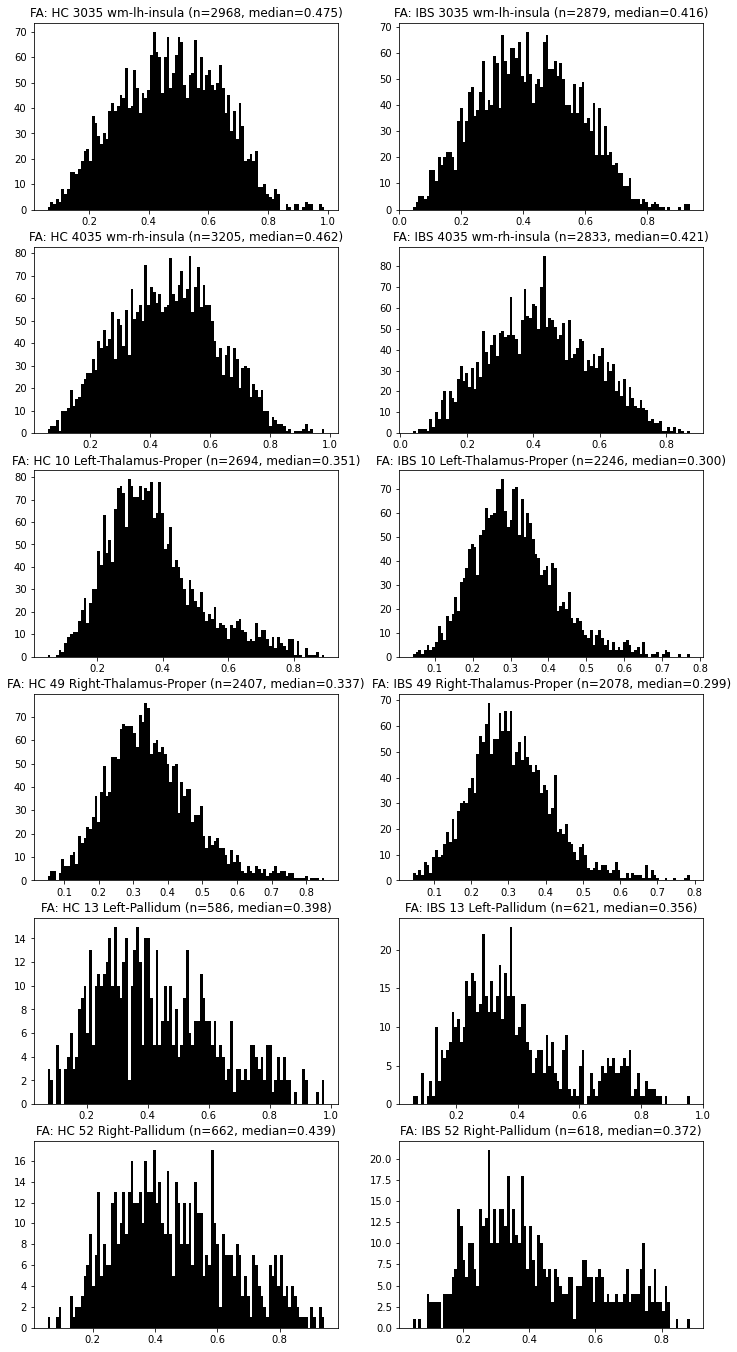

In [36]:
grps = ['HC', 'IBS']
rois = [3035, 4035, 10, 49, 13, 52]
wm_dict = {3035: 'wm-lh-insula', 
           4035: 'wm-rh-insula',
             10: 'Left-Thalamus-Proper',
             49: 'Right-Thalamus-Proper',
             13: 'Left-Pallidum',
             52: 'Right-Pallidum'}

fig, axes = plt.subplots(6, 2, figsize=(12, 24))
ax = axes.ravel()
k=0
for j in range(len(rois)):
    for i, g in enumerate(grps):
        roi_num = rois[j]
        roi_name = wm_dict[rois[j]]
        #print(i, g, j, roi_num, roi_name)
        fn = '%s/%s_%s_%s_FA.npy' % (outp_dir, g, roi_name, roi_num)
        np_array = np.load(fn)
        n = np_array.shape[0]
        med = np.median(np_array).round(4)
        ax[k].hist(np_array,bins=100, color='black')
        ax[k].set_title('FA: %s %d %s (n=%d, median=%.3f)' % (g, roi_num, roi_name, n, med))
        k=k+1
plt.show()

It seems that the median FA in the whiote matter for the left and right insula regions are slightly lower in the IBS group than in the HC group, e.g.  0.425 vs. 0.443 in the wm-lh-insula region and 0.415 vs. 0.431 in the wm-rh-insula region.

Can this slight "shift" in FA values to lower values in the IBS group happen by chance?

See e.g. https://towardsdatascience.com/how-to-assess-statistical-significance-in-your-data-with-permutation-tests-8bb925b2113d


## Permutation testing

According to Reproducible Research, Duke University: http://www2.stat.duke.edu/~ar182/rr/examples-gallery/PermutationTest.html  

Permutation tests are a group of nonparametric statistics. Here we use a permutation test to test the null hypothesis that two different groups come from the same distribution. The notation and examples shown here are borrowed from Efron and Tibshirani’s An Introduction to the Bootstrap [1]. 

[1] Efron, Bradley and Tibshirani, R. J., An Introduction to the Bootstrap, Chapman & Hall/CRC Monographs on Statistics & Applied Probability, 1994.

Our specific problem is that we observe two groups of data.

$\mbox{IBS}_{\rm{FA}}   \rightarrow \mathbf{z} = \{z_1, z_2, \ldots, z_n\}$ and  $\mbox{HC}_{\rm{FA}}  \rightarrow \mathbf{y} = \{y_1, y_2, \ldots, y_m\}$

and we are interested in thesting the null hypothesis that
$H_0: \mbox{IBS}_{\rm{FA}} = \mbox{HC}_{\rm{FA}}$

#### Functions for permuation testing and visualization

In [37]:
def run_permutation_test(pooled, sizeY, sizeZ):
    np.random.shuffle(pooled) 
    starY = pooled[:sizeY]
    starZ = pooled[-sizeZ:]
    return np.median(starY) - np.median(starZ)

In [38]:
def perm_test_visualize(mydir, roi_num, roi_name, numSamples):
    '''
    input:
      roi_num -   cf. FreeSurfer LUT
      roi_name -  cf. FreeSurfer LUT
    output:
      theta_hat - observed difference: median_FA(HC) - median_FA(IBS)
      diffCount - number of permutation occurences for which a permutated median is larger tahn observed median
      p_hat_perm - permutation test probability of observed difference: median_FA(HC) - median_FA(IBS)
      
    '''

    fnIBS = '%s/IBS_%s_%s_FA.npy' % (mydir, roi_name, roi_num)
    fnHC = '%s/HC_%s_%s_FA.npy' % (mydir, roi_name, roi_num)

    z = np.load(fnIBS)
    y = np.load(fnHC)
    
    n_z = len(z)
    n_y = len(y)

    pooled = np.hstack([y,z])
    delta = np.median(y) - np.median(z)
    
    estimates = np.array([], dtype=np.float64)  # initialize
    
    for i in range(numSamples):
        estimates = np.append(estimates, run_permutation_test(pooled, y.size, z.size))
    diffCount = len(np.where(estimates >= delta)[0])
    theta_hat = delta
    p_hat_perm = float(diffCount)/float(numSamples)
    
    title_txt1 = 'Distribution of FA values in HC (n=%d voxels) and in IBS (n=%d voxels) in the "%s" region' % (n_y, n_z, roi_name)
    fig1, axes1 = plt.subplots(1, 1, figsize=(10, 8))
    sns.histplot(y , color="blue", label="HC", kde=True)
    sns.histplot(z, color="red", label="IBS", kde=True)
    plt.legend()
    plt.title(title_txt1)
    plt.show()
    
    title_txt2 = 'Permutation testing (n=%d) for the difference in median in FA values between HC and IBS in the "%s" region \n Vertical line is the observed difference: median(HC_FA) - median(IBS_FA)  (%.4f; p<%.4f)' % (numSamples, roi_name, delta, p_hat_perm + 1.0/numSamples)
    fig2, axes2 = plt.subplots(1, 1, figsize=(10, 8))
    #sns.distplot(estimates, color="black", fit_kws={"color":"blue"}, kde=True)
    sns.histplot(estimates, color="black", kde=True)
    plt.axvline(delta, lw = 3, ls = ':', color = "black")
    plt.title(title_txt2)
    plt.show()
    
    return theta_hat, diffCount, p_hat_perm

In [39]:
grps = ['HC', 'IBS']
rois = [3035, 4035, 10, 49, 13, 52]
wm_dict = {3035: 'wm-lh-insula', 
           4035: 'wm-rh-insula',
             10: 'Left-Thalamus-Proper',
             49: 'Right-Thalamus-Proper',
             13: 'Left-Pallidum',
             52: 'Right-Pallidum'}
numSamples = 10000

#### Permutation testing analysis for FA within the "wm-lh-insula" region

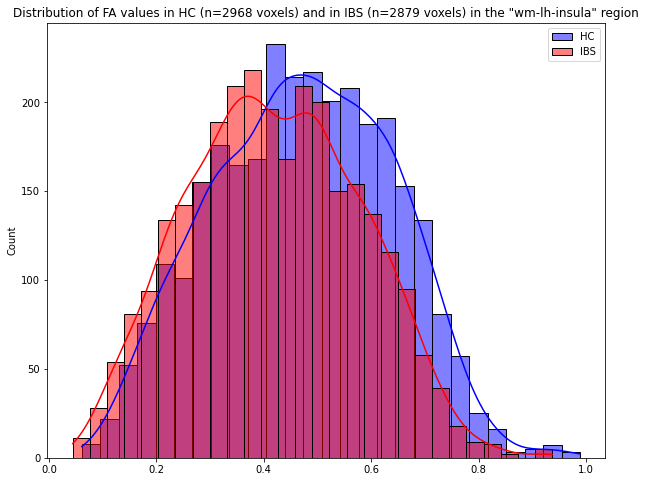

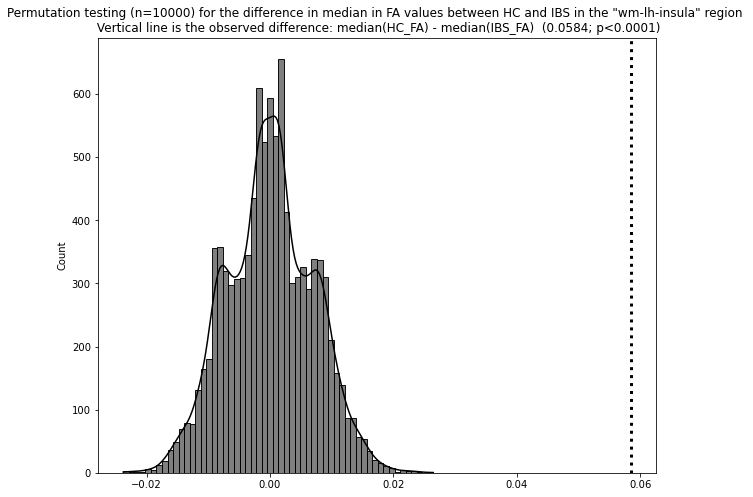

0.05843 0 0.0001
CPU times: user 2.56 s, sys: 17.2 ms, total: 2.58 s
Wall time: 2.36 s


In [40]:
%%time
roi_num = rois[0]
roi_name = wm_dict[rois[0]]

theta_hat_3035, diffCount_3035, p_hat_perm_3035 = perm_test_visualize(outp_dir, roi_num, roi_name, numSamples)
print(theta_hat_3035.round(5), diffCount_3035, p_hat_perm_3035 + 1.0/numSamples)

#### Permutation testing analysis for FA within the "wm-rh-insula" region

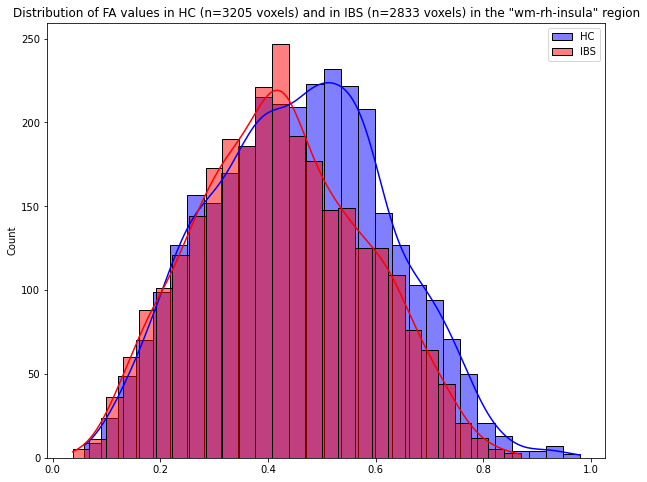

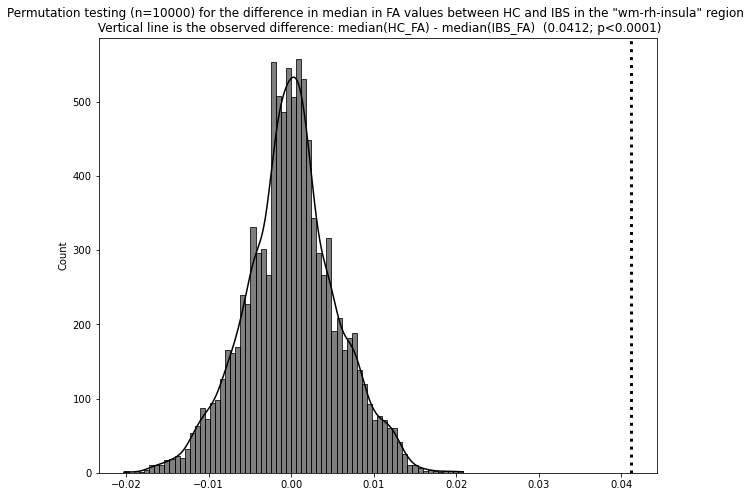

0.04122 0 0.0001
CPU times: user 2.76 s, sys: 15.4 ms, total: 2.77 s
Wall time: 2.38 s


In [41]:
%%time
roi_num = rois[1]
roi_name = wm_dict[rois[1]]

theta_hat_4035, diffCount_4035, p_hat_perm_4035 = perm_test_visualize(outp_dir, roi_num, roi_name, numSamples)
print(theta_hat_4035.round(5), diffCount_4035, p_hat_perm_4035 + 1.0/numSamples)

#### Permutation testing analysis for FA within the "Left-Thalamus-Proper" region

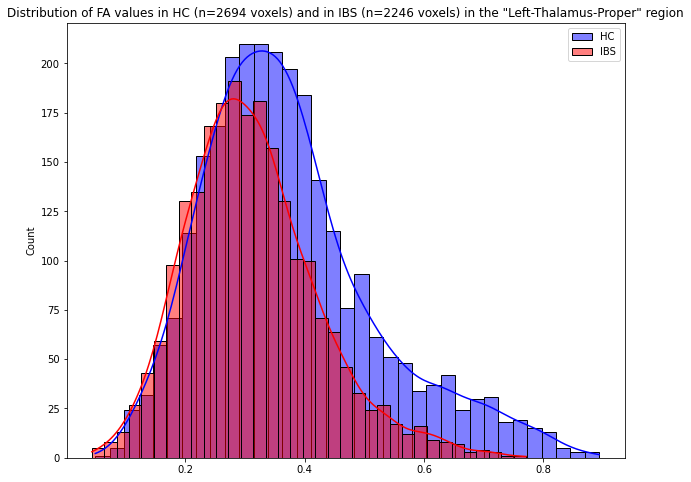

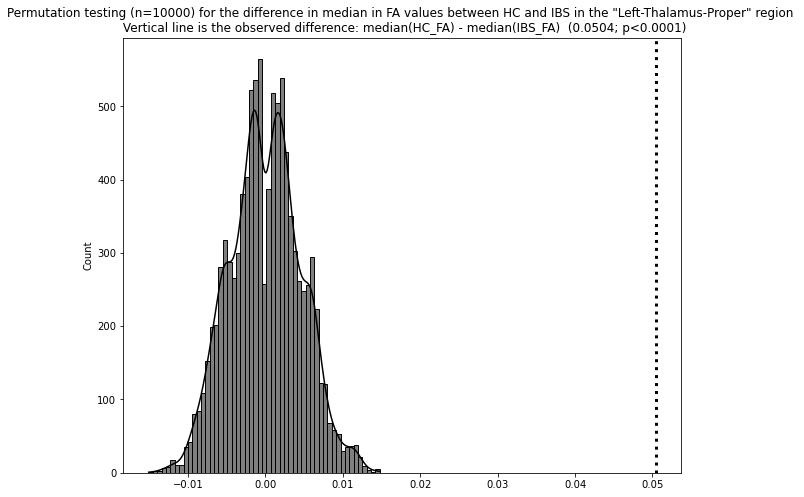

0.05045 0 0.0001
CPU times: user 2.51 s, sys: 16.6 ms, total: 2.52 s
Wall time: 2.17 s


In [42]:
%%time
roi_num = rois[2]
roi_name = wm_dict[rois[2]]

theta_hat_10, diffCount_10, p_hat_perm_10 = perm_test_visualize(outp_dir, roi_num, roi_name, numSamples)
print(theta_hat_10.round(5), diffCount_10, p_hat_perm_10 + 1.0/numSamples)

#### Permutation testing analysis for FA within the "Right-Thalamus-Proper" region

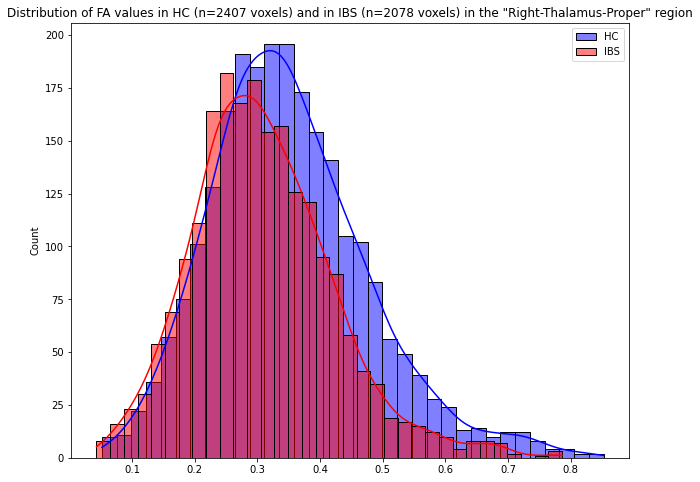

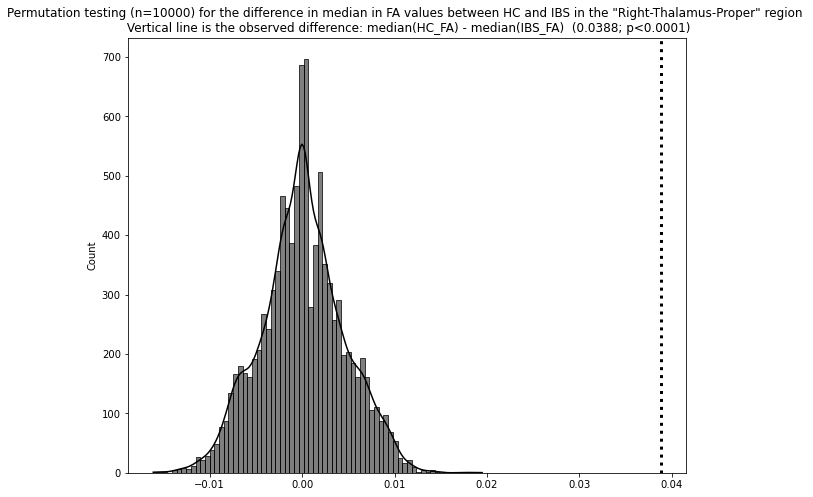

0.03877 0 0.0001
CPU times: user 2.5 s, sys: 15.8 ms, total: 2.52 s
Wall time: 2.11 s


In [43]:
%%time
roi_num = rois[3]
roi_name = wm_dict[rois[3]]

theta_hat_49, diffCount_49, p_hat_perm_49 = perm_test_visualize(outp_dir, roi_num, roi_name, numSamples)
print(theta_hat_49.round(5), diffCount_49, p_hat_perm_49 + 1.0/numSamples)

#### Permutation testing analysis for FA within the "Left-Pallidum" region

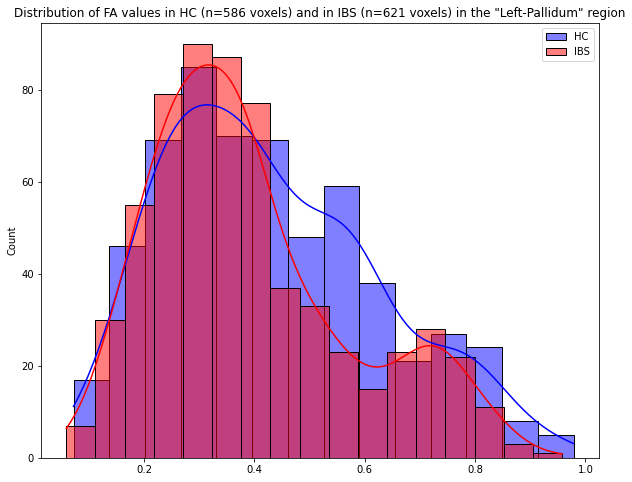

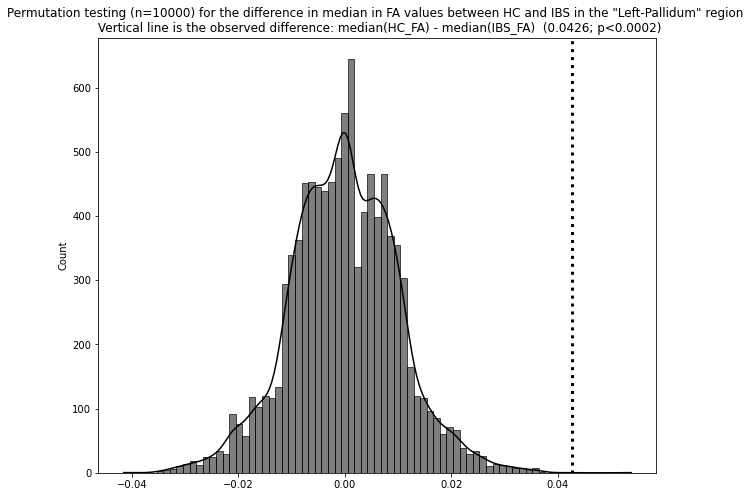

0.04257 1 0.0002
CPU times: user 1.92 s, sys: 16.5 ms, total: 1.94 s
Wall time: 1.56 s


In [44]:
%%time
roi_num = rois[4]
roi_name = wm_dict[rois[4]]

theta_hat_13, diffCount_13, p_hat_perm_13 = perm_test_visualize(outp_dir, roi_num, roi_name, numSamples)
print(theta_hat_13.round(5), diffCount_13, p_hat_perm_13 + 1.0/numSamples)

#### Permutation testing analysis for FA within the "Right-Pallidum" region

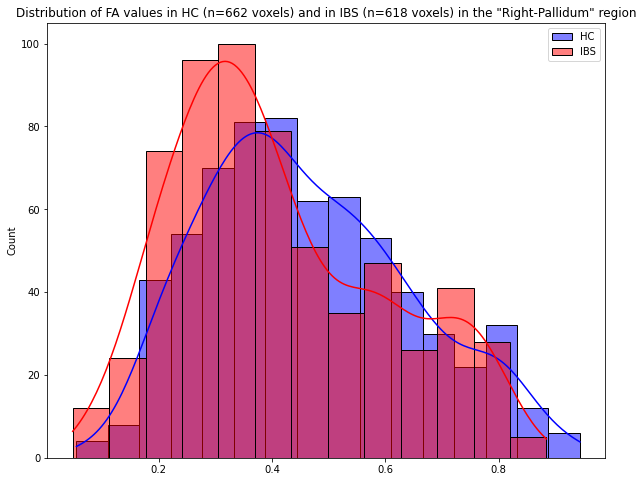

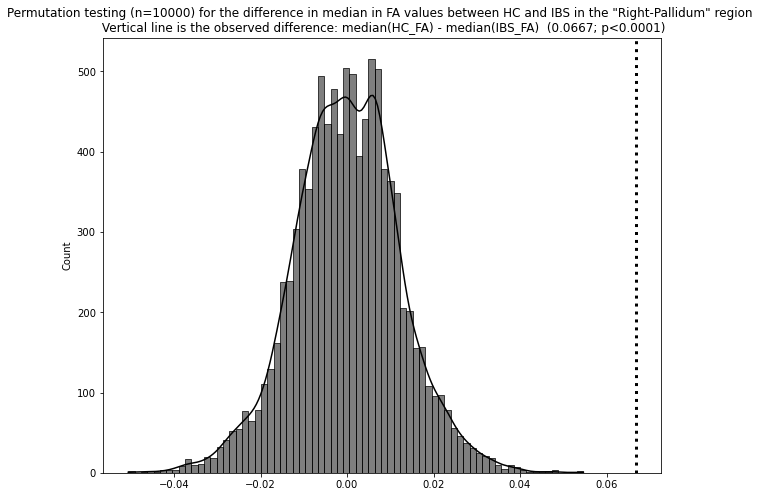

0.06671 0 0.0001
CPU times: user 1.79 s, sys: 14.1 ms, total: 1.8 s
Wall time: 1.41 s


In [45]:
%%time
roi_num = rois[5]
roi_name = wm_dict[rois[5]]

theta_hat_52, diffCount_52, p_hat_perm_52 = perm_test_visualize(outp_dir, roi_num, roi_name, numSamples)
print(theta_hat_52.round(5), diffCount_52, p_hat_perm_52 + 1.0/numSamples)

We note that the difference among the medians indicates that the HC group may have higher FA values in certain brain regions compared to IBS brain.